# Modules

In [8]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, RobustScaler, StandardScaler
from imblearn.combine import SMOTEENN

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve
from sklearn import metrics

from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier

# Preprocessing


>[0, 1, 2, 3, 6, 9, 11, 13, 16, 27, 31, 32, 34, 35, 51] are features with Information of *timestamp*, *Port*, *IP-address*, *payload*. <br>
>[54, 55] *mqtt.proto_len* and *mqtt.protoname* are same in meaning. Similarly *mqtt.topic_len* and *mqtt.topic* (one in numerics and other in string). <br>
>[11, 20, 45, 51, 60, 61] *icmp.unused*, *http.tls_port*, *dns.retransmit_request_in*, *mqtt.msg_decoded_as*, *mbtcp.trans_id*, *mbtcp.unit_id* are features with only *0* as value. <br>
>Dataset have Fault with Features *Frametime* and *arp.hw.size*. Both have their values exchanged sometimes. <br>
>Categorical Features have values '0' and '0.0', which are practically same, hence united before encoding. <br>
>Removed Target Labels *Attack_label* and *Attack_type*. <br>
 

In [9]:
def preprocess_edge_dataset(file_path):
    # Loading the data
    Raw_Data = pd.read_csv(file_path, low_memory=False)
    # Fixing the fault in 'arp.hw.size' where 'frame.time' equals '6.0'
    idx_hw_6 = Raw_Data[Raw_Data['frame.time'] == '6.0'].index
    Raw_Data.loc[idx_hw_6, 'arp.hw.size'] = 6.0  # Fix the value to 6.0
    # Droping unnecessary columns by index
    Columns_to_drop = [0, 1, 2, 3, 6, 9, 10, 11, 13, 16, 19, 27, 31, 32, 34, 35, 50, 51, 54, 55, 59, 60]
    Raw_Data = Raw_Data.drop(Raw_Data.columns[Columns_to_drop], axis=1)
    # Removing target labels
    attack_label = Raw_Data.pop('Attack_label') if 'Attack_label' in Raw_Data else None
    attack_type = Raw_Data.pop('Attack_type') if 'Attack_type' in Raw_Data else None
    # Replacing categorical feature values as specified
    categorical_features = ['http.request.method', 'http.referer', 'http.request.version', 'dns.qry.name.len', 'mqtt.conack.flags']
    for feature in categorical_features:
        Raw_Data[feature] = Raw_Data[feature].replace('0', '0.0')
    # mapping Attack_type to 6 numerical values
    mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
    attack_type = attack_type.map(mapping_dict)
    # Removing Duplicates
    duplicate_index = Raw_Data.duplicated()
    Raw_Data = Raw_Data[~duplicate_index]
    Raw_Data, attack_label, attack_type = Raw_Data[~duplicate_index], attack_label[~duplicate_index], attack_type[~duplicate_index]
    
    return Raw_Data, attack_label, attack_type

file_path = "../Data/ML-EdgeIIoT-dataset.csv"
Data, Attack_label, Attack_type = preprocess_edge_dataset(file_path)

# Encoding and Scaling

In [10]:
categorical_features = Data.select_dtypes(include=['object']).columns.tolist()
numerical_features = Data.select_dtypes(include=['float64']).columns.tolist()

numerical_transformer_rob = RobustScaler()
numerical_transformer_std = StandardScaler()
categorical_transformer_ohe = OneHotEncoder(sparse_output= False, drop='if_binary', min_frequency= 5)
categorical_transformer_tar = TargetEncoder()

transformer_rob_ohe = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_rob, numerical_features), # robust scaling
        ('cat', categorical_transformer_ohe, categorical_features) # one-hot encoding
    ])

transformer_rob_tar = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_rob, numerical_features), # robust scaling
        ('cat', categorical_transformer_tar, categorical_features) # target encoding
    ])

transformer_std_ohe = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_std, numerical_features), # standard scaling
        ('cat', categorical_transformer_ohe, categorical_features) # one-hot encoding
    ])

transformer_std_tar = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_std, numerical_features), # standard scaling
        ('cat', categorical_transformer_tar, categorical_features) # target encoding
    ])


# Functions

In [11]:
# Scoring function for LOF
def custom_scorer(clf, x, y):
    y_prd = clf.predict(x)
    y = y.replace({0:1, 1:-1})
    cm = metrics.confusion_matrix(y, y_prd)
    tn, fp, fn, tp = cm.ravel()
    f1 = metrics.f1_score(y, y_prd, pos_label= -1)
    roc = metrics.roc_auc_score(y, y_prd)
    # Composite score
    score = (tn + tp)/(tn + tp + fn + fp) #f1+roc 
    return score

# Getting the novelty data for LOF
def novelty_data(x, y, test = False):
    if (test == False):
        index_0 = np.where(y == 0)
        X_novelty = x[index_0]
        Y_novelty = np.ones(X_novelty.shape[0])
    else:
        X_novelty = x
        Y_novelty = np.where(y == 0, 1, -1)
    return X_novelty, Y_novelty

# Binary Hyperparameter

## Parameters

In [12]:
param_grids = {
    'KNN': {
        'model__n_neighbors': [2, 4, 6, 8],
        'model__weights': ['uniform', 'distance'],
        'model__leaf_size': [2, 4, 6, 8],
        'model__p': [1, 2]
    },
    'RF': {
        'model__n_estimators': [20, 50, 80],
        'model__max_features': [0.4, 0.8, 1],
        'model__max_depth': [None, 6, 10],
        'model__max_samples': [0.4, 0.8, 1],
        'model__criterion': ['gini', 'entropy']
    },
    'LOF': {
        'model__n_neighbors': [2, 6],
        'model__leaf_size': [6, 10],
        'model__metric': ['euclidean', 'manhattan', 'l1', 'l2', 'minkowski']
    }
}

## Pipeline and Models

In [13]:
def create_pipeline(model):
    return Pipeline([        
        ('smote', SMOTEENN(random_state= 22)),
        ('model', model)
    ])

models = {
    'KNN': KNeighborsClassifier(),
    'RF': RandomForestClassifier(),
    'LOF': LocalOutlierFactor(novelty= True)
}


## Gridsearch One Hot Encoded and Robust Scaled Dataset

In [155]:
Data_rob_ohe = transformer_rob_ohe.fit_transform(Data) # Robust scaling and One-hot encoding
X_train, X_learn, Y_train, Y_learn = train_test_split(Data_rob_ohe, Attack_label, train_size=10000, test_size=30000, random_state=22, stratify= Attack_type)

for model_name, model in models.items():
    pipeline = create_pipeline(model) # Created pipeline without Trafo. Training data is already transformed.
    grid_search = GridSearchCV(pipeline, param_grid=param_grids[model_name], cv=4, n_jobs=-1)

    if model_name is 'LOF':
        grid_search.set_params(scoring = custom_scorer)
        
    grid_search.fit(X_train, Y_train)
    grid_search.set_params(scoring = None)

    if model_name is 'LOF':
        train_size, train_scores, test_scores = learning_curve(grid_search.best_estimator_,
                                                               X_learn, Y_learn, train_sizes= [0.4, 0.6, 0.8, 1], cv= 3, n_jobs= -1, scoring= custom_scorer) # Learning curve   
    else:
        train_size, train_scores, test_scores = learning_curve(grid_search.best_estimator_,
                                                               X_learn, Y_learn, train_sizes= [0.4, 0.6, 0.8, 1], cv= 3, n_jobs= -1) # Learning curve   
    
    print(f"{model_name}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score :{grid_search.best_score_}")
    print(f"Training Time: {grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]}")
    print(pd.DataFrame({'train_size': train_size, 'train_scores': train_scores.mean(axis= 1), 'test_scores': test_scores.mean(axis= 1)}))
    print("\n")

KNN
Best parameters: {'model__leaf_size': 2, 'model__n_neighbors': 2, 'model__p': 1, 'model__weights': 'distance'}
Best score :0.9175
Training Time: 1.081918478012085
   train_size  train_scores  test_scores
0        8000      0.936125     0.920067
1       12000      0.946000     0.929900
2       16000      0.947938     0.931933
3       20000      0.947217     0.931967


RF
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__max_features': 1, 'model__max_samples': 0.4, 'model__n_estimators': 50}
Best score :0.9425
Training Time: 1.213284432888031
   train_size  train_scores  test_scores
0        8000      0.940375     0.939000
1       12000      0.940556     0.940867
2       16000      0.942458     0.941867
3       20000      0.940883     0.940867


LOF
Best parameters: {'model__leaf_size': 6, 'model__metric': 'manhattan', 'model__n_neighbors': 2}
Best score :0.2606
Training Time: 8.135800004005432
   train_size  train_scores  test_scores
0        8000     

## Gridsearch with Target Encoded and Robust Scaled Dataset

In [ ]:
Data_rob_tar = transformer_rob_tar.fit_transform(Data, Attack_label) # Robust scaling and Target encoding
X_train, X_learn, Y_train, Y_learn = train_test_split(Data_rob_tar, Attack_label, train_size=10000, test_size=30000, random_state=22, stratify= Attack_type)

for model_name, model in models.items():
    pipeline = create_pipeline(model) 
    grid_search = GridSearchCV(pipeline, param_grid=param_grids[model_name], cv=4, n_jobs=-1)

    if model_name is 'LOF':
        grid_search.set_params(scoring = custom_scorer)
        
    grid_search.fit(X_train, Y_train)
    grid_search.set_params(scoring = None)
    
    if model_name is 'LOF':
        train_size, train_scores, test_scores = learning_curve(grid_search.best_estimator_,
                                                               X_learn, Y_learn, train_sizes= [0.2, 0.4, 0.6], cv= 3, n_jobs= -1, scoring= custom_scorer) # Learning curve   
    else:
        train_size, train_scores, test_scores = learning_curve(grid_search.best_estimator_,
                                                               X_learn, Y_learn, train_sizes= [0.2, 0.4, 0.6, 0.8], cv= 3, n_jobs= -1) # Learning curve   
    
    print(f"{model_name}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score :{grid_search.best_score_}")
    print(f"Training Time: {grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]}")
    print(pd.DataFrame({'train_size': train_size, 'train_scores': train_scores.mean(axis= 1), 'test_scores': test_scores.mean(axis= 1)}))
    print("\n")
    

KNN
Best parameters: {'model__leaf_size': 2, 'model__n_neighbors': 2, 'model__p': 1, 'model__weights': 'distance'}
Best score :0.9175
Training Time: 1.0006172060966492
   train_size  train_scores  test_scores
0        8000      0.939792     0.923433
1       12000      0.944833     0.928433
2       16000      0.946583     0.930233
3       20000      0.945383     0.929700


RF
Best parameters: {'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 0.4, 'model__max_samples': 0.4, 'model__n_estimators': 80}
Best score :0.9509999999999998
Training Time: 1.5769773721694946
   train_size  train_scores  test_scores
0        8000      0.954083     0.945433
1       12000      0.956250     0.948233
2       16000      0.958313     0.949633
3       20000      0.959100     0.949567


LOF
Best parameters: {'model__leaf_size': 6, 'model__metric': 'manhattan', 'model__n_neighbors': 2}
Best score :0.2583
Training Time: 6.347138583660126
   train_size  train_scores  test_scores
0  

## SVC Gridsearch with Target Encoded and  Standardised

In [18]:
categorical_transformer = TargetEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline_svc = Pipeline([
        ('preprocessor', preprocessor),
        ('std', StandardScaler()),
        ('smote', SMOTEENN(random_state= 22)),
        ('model', SVC(probability= True))
    ])

X_train, X_val, Y_train, Y_val = train_test_split(Data, Attack_label, train_size= 3000, test_size=3000, random_state=22, stratify= Attack_type)

parameters= {'model__C':[1, 10, 100],
    'model__kernel': ['linear', 'poly', 'rbf'],
    'model__degree': [2, 3]}

grid_eval = GridSearchCV(pipeline_svc, parameters, cv=3, n_jobs=-1)
search_grid = grid_eval.fit(X_train, Y_train)

print(f"Best parameters: {grid_eval.best_params_}")
print(f"Best score: {grid_eval.best_score_}")

Best parameters: {'model__C': 1, 'model__degree': 3, 'model__kernel': 'poly'}
Best score: 0.8796666666666666


# Multiclass Hyperparameter

## Parameters

In [20]:
param_grids = {
    'KNN': {
        'model__n_neighbors': [2, 4, 6],
        'model__weights': ['uniform', 'distance'],
        'model__leaf_size': [2, 6, 10],
        'model__p': [1, 2]
    },
    'RF': {
        'model__n_estimators': [20, 50, 80, 100],
        'model__max_features': [0.2, 0.5, 0.8, 1],
        'model__max_depth': [6, 10, 12],
        'model__max_samples': [0.3, 0.5, 0.8],
        'model__criterion': ['gini', 'entropy']
    },
}

param_grids_SVM = { 
    'SVC': {
        'model__C': [10, 100, 1000],
        'model__kernel': ['poly', 'rbf', 'sigmoid'],
        'model__degree': [2, 3],
        #'model__gamma': ['scale', 'auto']
    },
    'linsvc': {
        'model__C': [10, 20, 30],
        'model__penalty': ['l1', 'l2'],
        'model__loss': ['hinge', 'squared_hinge']
    }
}


## Pipelines and Models

In [21]:
def create_pipeline(model):
    return Pipeline([
        ('smote', SMOTEENN(random_state= 22)),
        ('model', model)
    ])

models = {
    'KNN': KNeighborsClassifier(),
    'RF': RandomForestClassifier(), 
}

models_SVM = {
    'SVC': SVC(decision_function_shape='ovo'),
    'linsvc': LinearSVC(dual= 'auto', max_iter= 1500, fit_intercept= False)
}


## Gridsearch with One Hot Encoded and Robust Scaled Dataset

In [139]:
Data_rob_ohe = transformer_rob_ohe.fit_transform(Data) # Robust scaling and One-hot encoding
X_train, X_learn, Y_train, Y_learn = train_test_split(Data_rob_ohe, Attack_type, train_size= 6000, test_size= 30000, random_state= 22, stratify= Attack_type)

for model_name, model in models.items():
    pipeline = create_pipeline(model) # Created pipeline without Trafo. Training data is already transformed.
    grid_search = GridSearchCV(pipeline, param_grid= param_grids[model_name], cv= 4, n_jobs= -1)
        
    grid_search.fit(X_train, Y_train) # Hyperparameter
    train_size, train_scores, test_scores = learning_curve(grid_search.best_estimator_,
                                                           X_learn, Y_learn, train_sizes= [0.1, 0.3, 0.5, 0.8], cv= 3, n_jobs= -1) # Learning curve
    
    print(f"{model_name}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score :{grid_search.best_score_}")
    print(f"Training Time: {grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]}")
    print(pd.DataFrame({'train_size': train_size, 'train_scores': train_scores.mean(axis= 1), 'test_scores': test_scores.mean(axis= 1)}))
    print("\n")

KNN
Best parameters: {'model__leaf_size': 2, 'model__n_neighbors': 2, 'model__p': 1, 'model__weights': 'distance'}
Best score :0.7921666666666667
Training Time: 0.5217454433441162
   train_size  train_scores  test_scores
0        2000      0.816167     0.781567
1        6000      0.836222     0.804100
2       10000      0.845667     0.809267
3       16000      0.847083     0.815333


RF
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__max_features': 0.8, 'model__max_samples': 0.8, 'model__n_estimators': 20}
Best score :0.8631666666666667
Training Time: 0.7589134573936462
   train_size  train_scores  test_scores
0        2000      0.852333     0.831767
1        6000      0.878722     0.871633
2       10000      0.879500     0.874433
3       16000      0.881521     0.880000




## Gridsearch with Target Encoded and Robust Scaled Dataset

In [22]:
Data_rob_tar = transformer_rob_tar.fit_transform(Data, Attack_type) # Robust scaling and Target encoding
X_train, X_learn, Y_train, Y_learn = train_test_split(Data_rob_tar, Attack_type, train_size= 10000, test_size= 50000, random_state= 22, stratify= Attack_type)

for model_name, model in models.items():
    pipeline = create_pipeline(model) # Created pipeline with Trafo.
    grid_search = GridSearchCV(pipeline, param_grid= param_grids[model_name], cv= 4, n_jobs= -1)
      
    grid_search.fit(X_train, Y_train) # Hyperparameter
    train_size, train_scores, test_scores = learning_curve(grid_search.best_estimator_,
                                                           X_learn, Y_learn, train_sizes= [0.1, 0.3, 0.5, 0.8, 1], cv= 3, n_jobs= -1) # Learning curve

    print(f"{model_name}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_}")
    print(f"Training Time: {grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]}")
    print(pd.DataFrame({'train_size': train_size, 'train_scores': train_scores.mean(axis= 1), 'test_scores': test_scores.mean(axis= 1)}))
    print("\n")

KNN
Best parameters: {'model__leaf_size': 2, 'model__n_neighbors': 2, 'model__p': 1, 'model__weights': 'distance'}
Best score: 0.8189
Training Time: 1.523353934288025
   train_size  train_scores  test_scores
0        3333      0.842484      0.80320
1        9999      0.857252      0.82172
2       16666      0.861314      0.82962
3       26666      0.864134      0.83168
4       33333      0.863409      0.83360


RF
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 12, 'model__max_features': 0.8, 'model__max_samples': 0.8, 'model__n_estimators': 80}
Best score: 0.8926
Training Time: 6.842196881771088
   train_size  train_scores  test_scores
0        3333      0.890689      0.87766
1        9999      0.894189      0.88820
2       16666      0.901456      0.89796
3       26666      0.904998      0.90276
4       33333      0.906029      0.90356




## SVC Gridsearch with Target Encoded and Standard Scaled Datset

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(Data, Attack_type, train_size= 5000, test_size=5000, random_state=22, stratify= Attack_type)

C_Param_SVC = [100, 1e3, 1e4]
#C_Param_LinSVC = [1, 10, 100, 1000]

categorical_transformer = TargetEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

for model_name, model in models_SVM.items():

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('std:', StandardScaler()),
        ('smote', SMOTEENN(random_state= 22)),
        ('model', model)
    ])

    grid_search = GridSearchCV(pipeline, param_grid= param_grids_SVM[model_name], cv= 2, n_jobs= -1)
      
    grid_search.fit(X_train, Y_train) # Hyperparameter
    
    print(f"{model_name}")
    #if model_name is 'SVC': # Validation curve
    train_scores, test_scores = validation_curve(grid_search.best_estimator_, X_val, Y_val, param_name= 'model__C', param_range= C_Param_SVC, cv=3)
    print(pd.DataFrame({'C_Param': C_Param_SVC, 'train_scores': train_scores.mean(axis= 1), 'test_scores': test_scores.mean(axis= 1)}))
    #else:
    #    train_scores, test_scores = validation_curve(grid_search.best_estimator_, X_val, Y_val, param_name= 'model__C', param_range= C_Param_LinSVC, cv=3) 
    #    print(pd.DataFrame({'C_Param': C_Param_LinSVC, 'train_scores': train_scores.mean(axis= 1), 'test_scores': test_scores.mean(axis= 1)}))
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_}")
    print(f"Training Time: {grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]}")

SVC
   C_Param  train_scores  test_scores
0    100.0      0.605300     0.604799
1   1000.0      0.634601     0.626398
2  10000.0      0.666398     0.648003
Best parameters: {'model__C': 1000, 'model__degree': 3, 'model__kernel': 'rbf'}
Best score: 0.6592
Training Time: 0.35113775730133057


/home/user/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinea

linsvc
   C_Param  train_scores  test_scores
0    100.0      0.579600     0.578799
1   1000.0      0.568099     0.565800
2  10000.0      0.581100     0.577398
Best parameters: {'model__C': 30, 'model__loss': 'squared_hinge', 'model__penalty': 'l2'}
Best score: 0.6024
Training Time: 9.442174553871155


In [51]:
X_train, X_learn, Y_train, Y_learn = train_test_split(Data, Attack_type, train_size= 3000, test_size=15000, random_state=22, stratify= Attack_type)
pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('std:', StandardScaler()),
        ('smote', SMOTEENN(random_state= 22)),
        ('model', SVC(C = 100, gamma = 'auto', kernel = 'rbf'))
    ])
train_size, train_scores, test_scores = learning_curve(pipeline, X_learn, Y_learn, train_sizes= [0.1, 0.2, 0.3, 0.5, 0.8],
                                                       cv= 3, n_jobs= -1) # Learning curve
print(pd.DataFrame({'train_size': train_size, 'train_scores': train_scores.mean(axis= 1), 'test_scores': test_scores.mean(axis= 1)}))

   train_size  train_scores  test_scores
0        1000      0.586667     0.574267
1        2000      0.652500     0.634800
2        3000      0.666556     0.652067
3        5000      0.675933     0.671933
4        8000      0.677625     0.673400


## SVC Gridsearch with One Hot Encoded and Standard Scaled Datset

In [132]:
X_train, X_val, Y_train, Y_val = train_test_split(Data, Attack_type, train_size=3000, test_size=3000, random_state=22, stratify= Attack_type)

C_Param_SVC = [100, 1e3, 1e4, 1e5]
C_Param_LinSVC = [1, 10, 100, 1000]

X_train, Y_train = ColumnTransformer(transformers=[('cat', categorical_transformer_ohe, categorical_features)], remainder='passthrough').fit_transform(X_train), Y_train
X_train, Y_train = StandardScaler().fit_transform(X_train), Y_train

X_val, Y_val = ColumnTransformer(transformers=[('cat', categorical_transformer_ohe, categorical_features)], remainder='passthrough').fit_transform(X_val), Y_val
X_val, Y_val = StandardScaler().fit_transform(X_val), Y_val

for model_name, model in models_SVM.items():
    pipeline = Pipeline([
        ('smote', SMOTEENN(random_state= 22)),
        ('model', model)
    ])

    grid_search = GridSearchCV(pipeline, param_grid= param_grids_SVM[model_name], cv= 3, n_jobs= -1)
      
    grid_search.fit(X_train, Y_train) # Hyperparameter
    
    print(f"{model_name}")
    if model_name is 'SVC': # Validation curve
        train_scores, test_scores = validation_curve(grid_search.best_estimator_, X_val, Y_val, param_name= 'model__C', param_range= C_Param_SVC, cv=3)
        print(pd.DataFrame({'C_Param': C_Param_SVC, 'train_scores': train_scores.mean(axis= 1), 'test_scores': test_scores.mean(axis= 1)}))
    else:
        train_scores, test_scores = validation_curve(grid_search.best_estimator_, X_val, Y_val, param_name= 'model__C', param_range= C_Param_LinSVC, cv=3) 
        print(pd.DataFrame({'C_Param': C_Param_LinSVC, 'train_scores': train_scores.mean(axis= 1), 'test_scores': test_scores.mean(axis= 1)}))
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score for: {grid_search.best_score_}")
    print(f"Training Time: {grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]}")
    print("\n")

SVC
    C_Param  train_scores  test_scores
0     100.0      0.665000     0.652000
1    1000.0      0.678167     0.656667
2   10000.0      0.693500     0.664667
3  100000.0      0.695167     0.664667
Best parameters: {'model__degree': 2, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Best score for: 0.5776666666666667
Training Time: 0.21613216400146484




/home/user/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinea

linsvc
   C_Param  train_scores  test_scores
0        1      0.589833     0.584667
1       10      0.603833     0.600333
2      100      0.606167     0.603667
3     1000      0.606500     0.604667
Best parameters: {'model__loss': 'squared_hinge', 'model__penalty': 'l1'}
Best score for: 0.5973333333333334
Training Time: 2.9456117153167725




# Test

,Accuracy,Precison,Recall,F1-Score
1,0.8373,0.995164,0.854648,0.919569
2,0.8373,0.703939,0.911443,0.794363
3,0.8373,0.370787,1.000000,0.540984
4,0.8373,0.764956,0.742102,0.753355
5,0.8373,0.869621,0.806392,0.836813
6,0.8373,0.825860,0.888961,0.856249


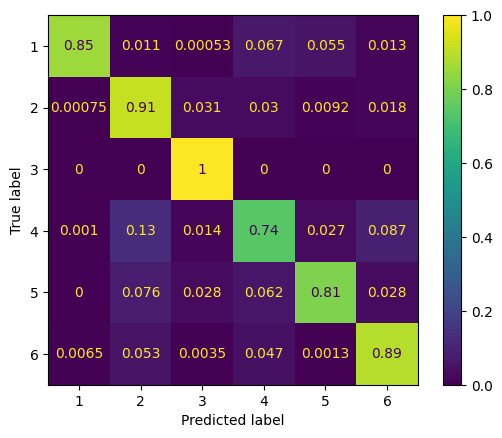

In [98]:
from sklearn.calibration import CalibratedClassifierCV 
svc = SVC(C= 1e3, kernel= 'rbf', gamma= 'auto', probability= True)
cal_svc = CalibratedClassifierCV(svc, cv= 3)

pipeline_svc = Pipeline([
        ('TargetEncoder', TargetEncoder()),
        ('std', StandardScaler()),
        ('smote', SMOTEENN(random_state= 22)),
        ('svc', cal_svc)
    ])

X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_type, train_size= 3500, test_size=30000, random_state=22, stratify= Attack_type)

pipeline_svc.fit(X_train, Y_train)
Y_pred = pipeline_svc.predict(X_test)

#Evaluation Function
def evaluate_clf(model, test: np.ndarray, pred: np.ndarray, display:bool = True) -> None:
    df_metric = pd.DataFrame({'Accuracy': metrics.accuracy_score(test, pred),
                              'Precison': metrics.precision_score(test, pred, average= None),
                              'Recall': metrics.recall_score(test, pred, average= None),
                              'F1-Score': metrics.f1_score(test, pred, average= None)
                            }, index= [1,2,3,4,5,6])
    if display:
        cm = metrics.confusion_matrix(test, pred, normalize= 'true', labels=model.classes_) 
        metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
    return df_metric

evaluate_clf(pipeline_svc, Y_test, Y_pred)

,Accuracy,Precison,Recall,F1-Score
1,0.8315,0.974814,0.865510,0.916916
2,0.8315,0.832277,0.914677,0.871534
3,0.8315,0.320819,0.813853,0.460220
4,0.8315,0.877279,0.677541,0.764581
5,0.8315,0.891826,0.804363,0.845839
6,0.8315,0.622473,0.919697,0.742443


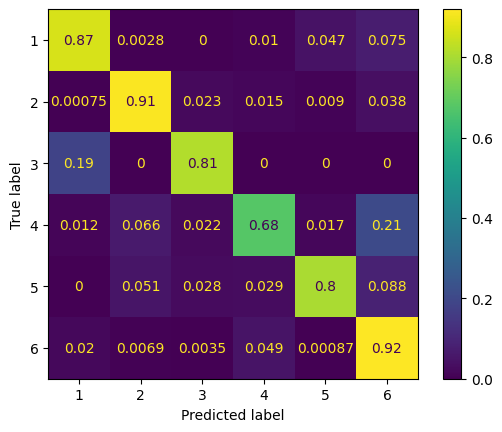

In [101]:
from sklearn.calibration import CalibratedClassifierCV 
linsvc = LinearSVC(loss= 'squared_hinge', penalty= 'l2', dual= 'auto', max_iter= 2000, fit_intercept= False)
cal_svc = CalibratedClassifierCV(linsvc, cv= 3)

pipeline_svc = Pipeline([
        ('TargetEncoder', TargetEncoder()),
        ('std', StandardScaler()),
        ('smote', SMOTEENN(random_state= 22)),
        ('svc', cal_svc)
    ])

X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_type, train_size= 3500, test_size=30000, random_state=22, stratify= Attack_type)

pipeline_svc.fit(X_train, Y_train)
Y_pred = pipeline_svc.predict(X_test)

#Evaluation Function
def evaluate_clf(model, test: np.ndarray, pred: np.ndarray, display:bool = True) -> None:
    df_metric = pd.DataFrame({'Accuracy': metrics.accuracy_score(test, pred),
                              'Precison': metrics.precision_score(test, pred, average= None),
                              'Recall': metrics.recall_score(test, pred, average= None),
                              'F1-Score': metrics.f1_score(test, pred, average= None)
                            }, index= [1,2,3,4,5,6])
    if display:
        cm = metrics.confusion_matrix(test, pred, normalize= 'true', labels=model.classes_) 
        metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
    return df_metric

evaluate_clf(pipeline_svc, Y_test, Y_pred)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV 
svc = SVC(C= 1e4, kernel= 'rbf', probability= True)
cal_svc = CalibratedClassifierCV(svc, cv= 3)

pipeline_svc = Pipeline([
        ('transformer', transformer_std_tar()),
        ('smote', SMOTEENN(random_state= 22)),
        ('cal_svc', cal_svc)
    ])

X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_type, train_size= 3000, test_size=8000, random_state=22, stratify= Attack_type)

pipeline_svc.fit(X_train, Y_train)
Y_pred = pipeline_svc.predict(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(Y_test, Y_pred, labels=[0, 1]).ravel()
pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(Y_test, Y_pred)*100,                              
                              'Precision':metrics.precision_score(Y_test, Y_pred, pos_label= 1, average = 'binary')*100,
                              'Recall': metrics.recall_score(Y_test, Y_pred, pos_label= 1, average = 'binary')*100,
                              'F1-Score': metrics.f1_score(Y_test, Y_pred, pos_label= 1, average = 'binary' )*100,
                              'FPR':(fp/(tn+fp))*100}, index= ['SVC'])


,Average Accuracy Score,Precision,Recall,F1-Score,FPR
SVC,71.956667,97.791674,68.396375,80.494308,8.484848


In [32]:
X_test, Y_test = novelty_data(X_test, Y_test, test = True)
X_train, Y_train = novelty_data(X_train, Y_train)

lof = LocalOutlierFactor(novelty= True, n_neighbors= 2, leaf_size= 6, metric= 'manhattan').fit(X_train)
Y_pred = lof.predict(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(Y_test, Y_pred, labels=[1, -1]).ravel()
pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(Y_test, Y_pred)*100,                              
                              'Precision':metrics.precision_score(Y_test, Y_pred, pos_label= -1, average = 'binary')*100,
                              'Recall': metrics.recall_score(Y_test, Y_pred, pos_label= -1, average = 'binary')*100,
                              'F1-Score': metrics.f1_score(Y_test, Y_pred, pos_label= -1, average = 'binary' )*100,
                              'FPR':(fp/(tn+fp))*100}, index= ['LOF'])

,Average Accuracy Score,Precision,Recall,F1-Score,FPR
LOF,86.796667,97.816672,86.319937,91.7094,10.584416


   Accuracy  Precison    Recall  F1-Score
1   0.83214  0.989835  0.858576  0.919545
2   0.83214  0.866367  0.718848  0.785743
3   0.83214  0.385271  1.000000  0.556239
4   0.83214  0.731439  0.824696  0.775273
5   0.83214  0.744821  0.835345  0.787490
6   0.83214  0.855291  0.873896  0.864493
   Accuracy  Precison    Recall  F1-Score
1   0.84088  0.944950  0.868607  0.905172
2   0.84088  0.834406  0.938442  0.883371
3   0.84088  1.000000  0.603381  0.752636
4   0.84088  0.871109  0.717906  0.787122
5   0.84088  0.808729  0.823374  0.815986
6   0.84088  0.697706  0.888896  0.781782


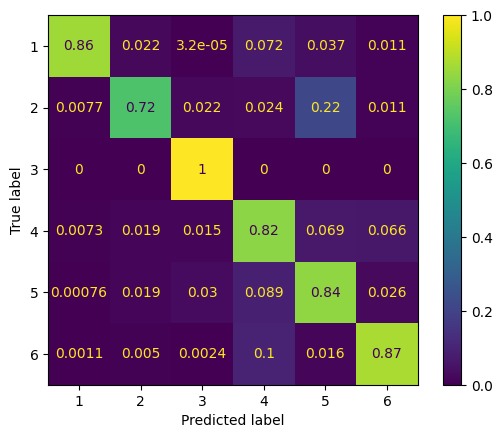

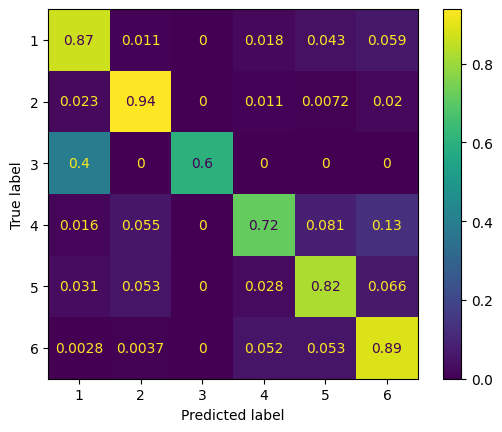

In [ ]:
def create_pipeline(model):
    return Pipeline([
        ('encoder', TargetEncoder()),
        ('scale', StandardScaler()),
        ('smote', SMOTEENN(random_state= 22)),
        ('model', model)
    ])

X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_type, train_size=10000, test_size=100000, random_state=22, stratify= Attack_type)

#clf1 = KNeighborsClassifier(n_neighbors= 4, p= 1, weights= 'uniform', leaf_size= 2)
#clf2 = RandomForestClassifier(criterion= 'entropy', max_depth= 12, max_features= 0.8, max_samples= 0.8, n_estimators= 100)

clf1 = KNeighborsClassifier(n_neighbors= 2, p= 1, weights= 'distance', leaf_size= 2, algorithm= 'auto')
clf2 = RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 0.8, max_samples= 0.8, n_estimators= 80, oob_score= True)

pipeline1 = create_pipeline(clf1)
pipeline2 = create_pipeline(clf2)

pipeline1.fit(X_train, Y_train)
pipeline2.fit(X_train, Y_train)

Y_pred1 = pipeline1.predict(X_test)
Y_pred2 = pipeline2.predict(X_test)

import matplotlib.pyplot as plt
#Evaluation Function
def evaluate_clf(model, test: np.ndarray, pred: np.ndarray, display:bool = True) -> None:
    df_metric = pd.DataFrame({'Accuracy': metrics.accuracy_score(test, pred),
                              'Precison': metrics.precision_score(test, pred, average= None),
                              'Recall': metrics.recall_score(test, pred, average= None),
                              'F1-Score': metrics.f1_score(test, pred, average= None)
                            }, index= [1,2,3,4,5,6])
    if display:
        cm = metrics.confusion_matrix(test, pred, normalize= 'true', labels=model.classes_) 
        metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
    return df_metric

#Evaluation
print(evaluate_clf(clf1, Y_test, Y_pred1))
print(evaluate_clf(clf2, Y_test, Y_pred2))


   Accuracy  Precison    Recall  F1-Score
1   0.80753  0.967177  0.794493  0.872371
2   0.80753  0.720840  0.849873  0.780057
3   0.80753  0.380079  0.997399  0.550413
4   0.80753  0.708308  0.780445  0.742629
5   0.80753  0.874614  0.774881  0.821732
6   0.80753  0.755167  0.863636  0.805768
   Accuracy  Precison    Recall  F1-Score
1   0.87702  0.993825  0.894643  0.941629
2   0.87702  0.888691  0.929936  0.908846
3   0.87702  0.381259  1.000000  0.552046
4   0.87702  0.673196  0.940089  0.784566
5   0.87702  0.980048  0.779903  0.868595
6   0.87702  0.988986  0.833831  0.904806


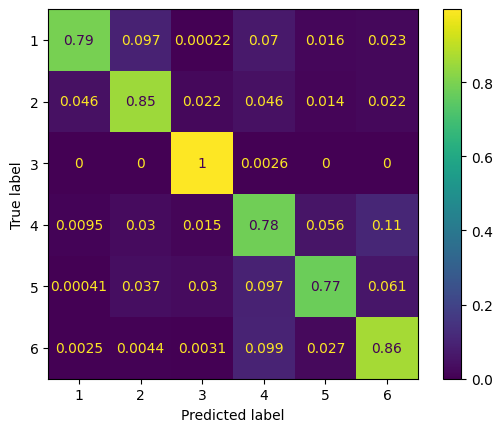

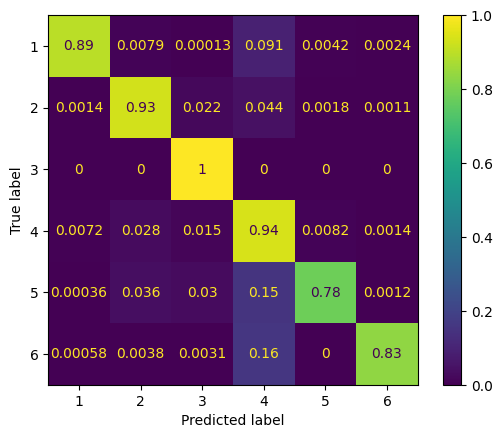

In [143]:
def create_pipeline(model):
    return Pipeline([
        ('scale', transformer_rob_tar),
        ('smote', SMOTEENN(random_state= 22)),
        ('model', model)
    ])

X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_type, train_size=10000, test_size=100000, random_state=22, stratify= Attack_type)

clf1 = KNeighborsClassifier(n_neighbors= 2, p= 1, weights= 'distance', leaf_size= 2, algorithm= 'auto')
clf2 = RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 0.8, max_samples= 0.8, n_estimators= 80, oob_score= True)

pipeline1 = create_pipeline(clf1)
pipeline2 = create_pipeline(clf2)

pipeline1.fit(X_train, Y_train)
pipeline2.fit(X_train, Y_train)

Y_pred1 = pipeline1.predict(X_test)
Y_pred2 = pipeline2.predict(X_test)

import matplotlib.pyplot as plt
#Evaluation Function
def evaluate_clf(model, test: np.ndarray, pred: np.ndarray, display:bool = True) -> None:
    df_metric = pd.DataFrame({'Accuracy': metrics.accuracy_score(test, pred),
                              'Precison': metrics.precision_score(test, pred, average= None),
                              'Recall': metrics.recall_score(test, pred, average= None),
                              'F1-Score': metrics.f1_score(test, pred, average= None)
                            }, index= [1,2,3,4,5,6])
    if display:
        cm = metrics.confusion_matrix(test, pred, normalize= 'true', labels=model.classes_) 
        metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
    return df_metric

#Evaluation
print(evaluate_clf(clf1, Y_test, Y_pred1))
print(evaluate_clf(clf2, Y_test, Y_pred2))
